In [27]:
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem import rdchem
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit.Chem.Descriptors import ExactMolWt
import umap

import numpy as np
from sklearn.decomposition import PCA
from dataloader import DataLoader

import matplotlib as mpl
from collections import Counter
mpl.rcParams['figure.facecolor'] = 'white'

In [28]:
def get_elements(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
        return tuple(sorted(elements))
    else:
        return []
    
def is_chiral(mol):
    chiral_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
    return len(chiral_centers) > 0

def check_cis_trans_isomerism(mol):
    has_cis_trans = False
    for bond in mol.GetBonds():
        # Check if the bond is a double bond
        if bond.GetBondType() == rdchem.BondType.DOUBLE:
            # Check if the double bond has stereochemistry information
            stereo = bond.GetStereo()
            if stereo in [rdchem.BondStereo.STEREOZ, rdchem.BondStereo.STEREOE, rdchem.BondStereo.STEREOCIS, rdchem.BondStereo.STEREOTRANS]:
                has_cis_trans = True
                break

    return has_cis_trans

In [29]:
#df = pd.read_csv("datasets/leffingwell/leffingwell_combined.csv")

df = pd.read_csv("datasets/mayhew_2022/mayhew_2022_combined.csv")

df['rdkit'] = df.apply(lambda row: Chem.MolFromSmiles(row['IsomericSMILES']), axis=1)

In [5]:
df['morgfp'] = df.apply(lambda row: GetMorganFingerprintAsBitVect(row['rdkit'], radius=3, nBits=2048), axis=1)
df['fp'] = df.apply(lambda row: row['morgfp'].ToList(), axis=1)
umap_model = umap.UMAP(metric = "jaccard",
                       densmap=True,
                       random_state=42,
                       low_memory = False)
X_umap = umap_model.fit_transform(list(df['morgfp']))
df["UMAP_0"], df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

/home/chertian/anaconda3/envs/ml/lib/python3.7/site-packages/umap/umap_.py:1804: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


Text(0.5, 1.0, 'Leffingwell Morgan Fingerprints')

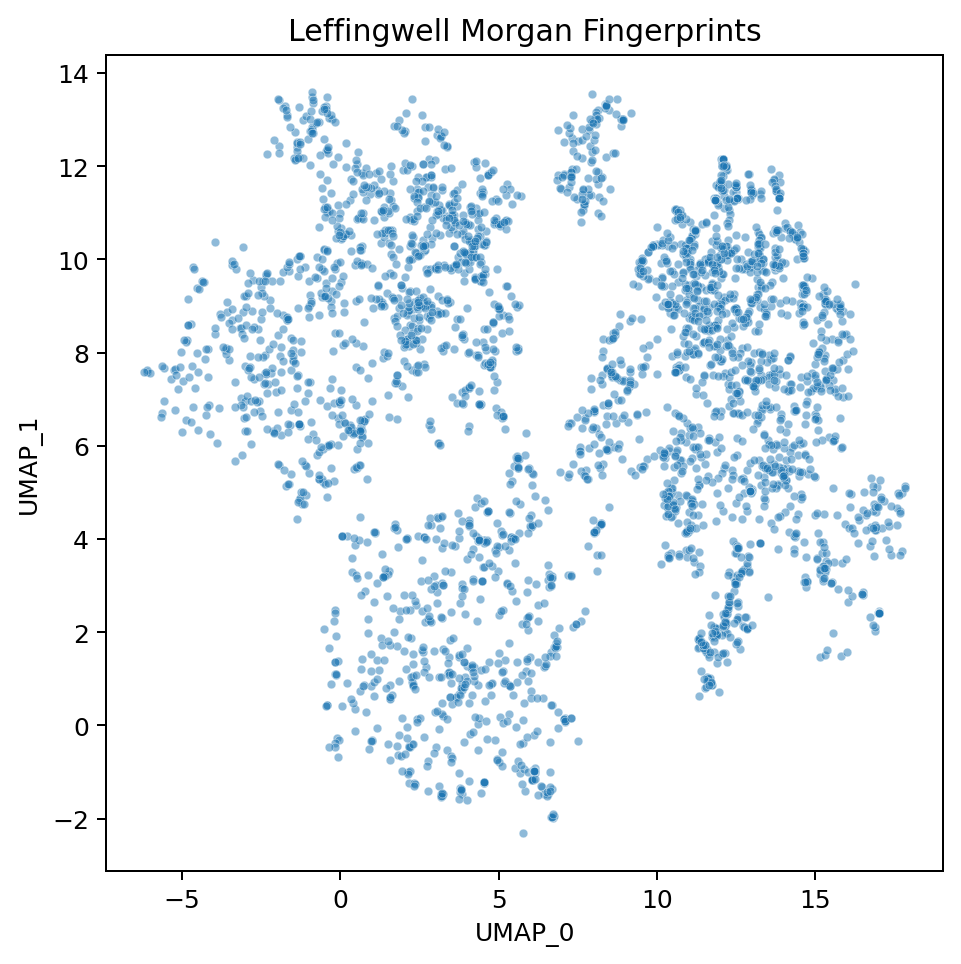

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
#g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=df, ax=ax, hue='is_odor', s=12, alpha=0.5)
g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=df, ax=ax, s=12, alpha=0.5)
ax.set_title("Leffingwell Morgan Fingerprints")

[0.07199552 0.04354637 0.03354081 0.02554751]


Text(0, 0.5, 'PC1 (4.4%)')

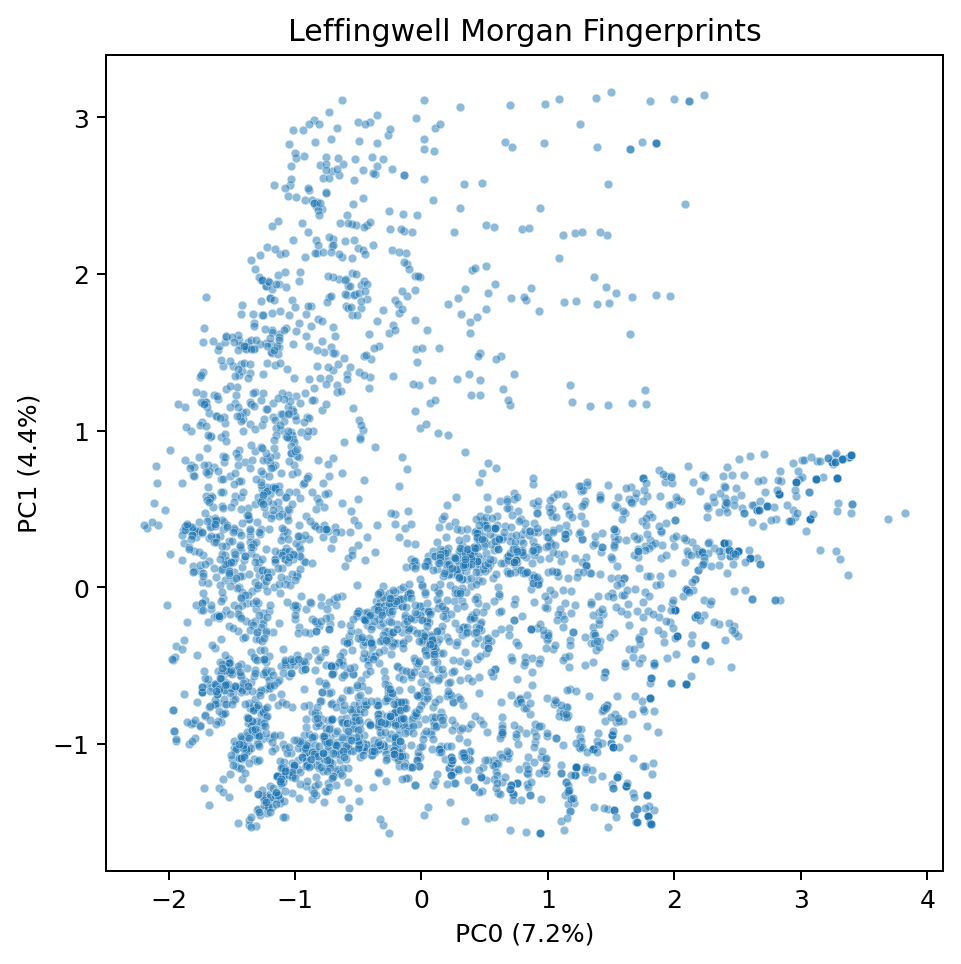

In [7]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(df['fp'].to_list())
print(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
#g = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], ax=ax, hue=df["is_odor"], s=12, alpha=0.5)
g = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], ax=ax, s=12, alpha=0.5)
ax.set_title("Leffingwell Morgan Fingerprints")
ax.set_xlabel(f"PC0 ({pca.explained_variance_ratio_[0]*100:.01f}%)")
ax.set_ylabel(f"PC1 ({pca.explained_variance_ratio_[1]*100:.01f}%)")


Text(0.5, 1.0, 'Leffingwell Morgan Fingerprints PC Cumulative')

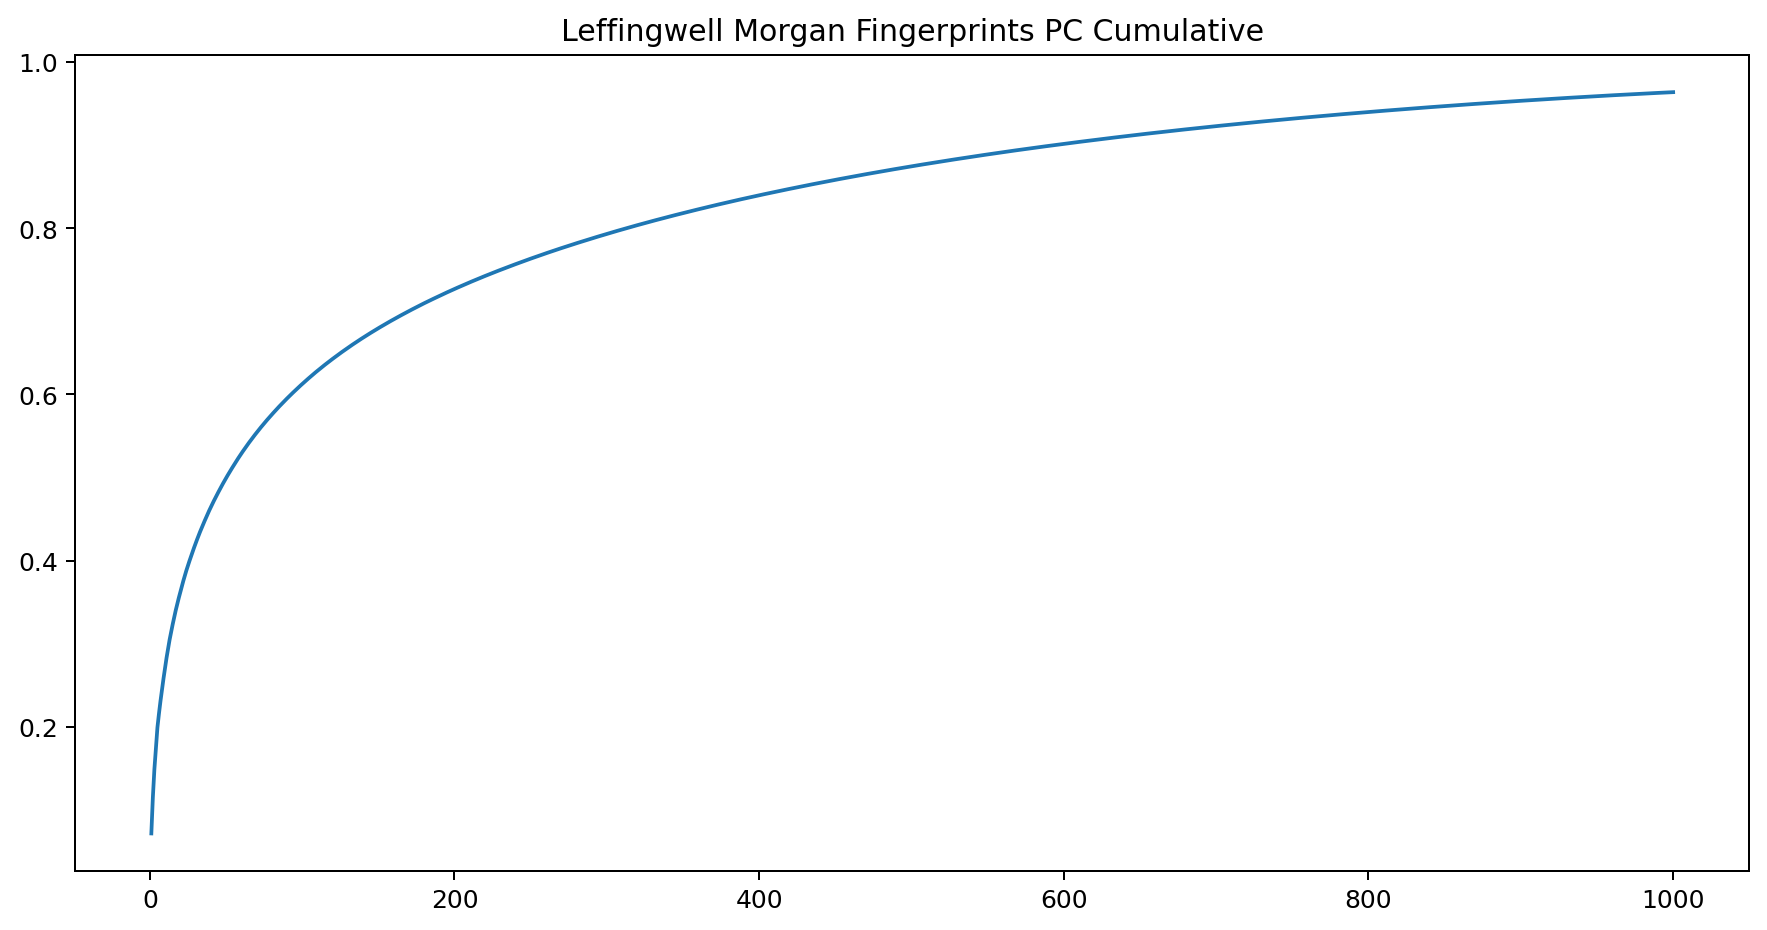

In [8]:
pca = PCA(n_components=1000)
principalComponents = pca.fit_transform(df['fp'].to_list())
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=180)
g = sns.lineplot(x=range(1,len(cumulative_variance_explained)+1), y=cumulative_variance_explained)
ax.set_title("Leffingwell Morgan Fingerprints PC Cumulative")

In [35]:
df['mw']

0         16.031300
1         26.015650
2         54.010565
3        117.941812
4         56.026215
           ...     
1793    1134.369764
1794     822.403786
1795      88.034671
1796      90.050321
1797     104.065971
Name: mw, Length: 1798, dtype: float64

/home/chertian/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':
/home/chertian/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/chertian/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


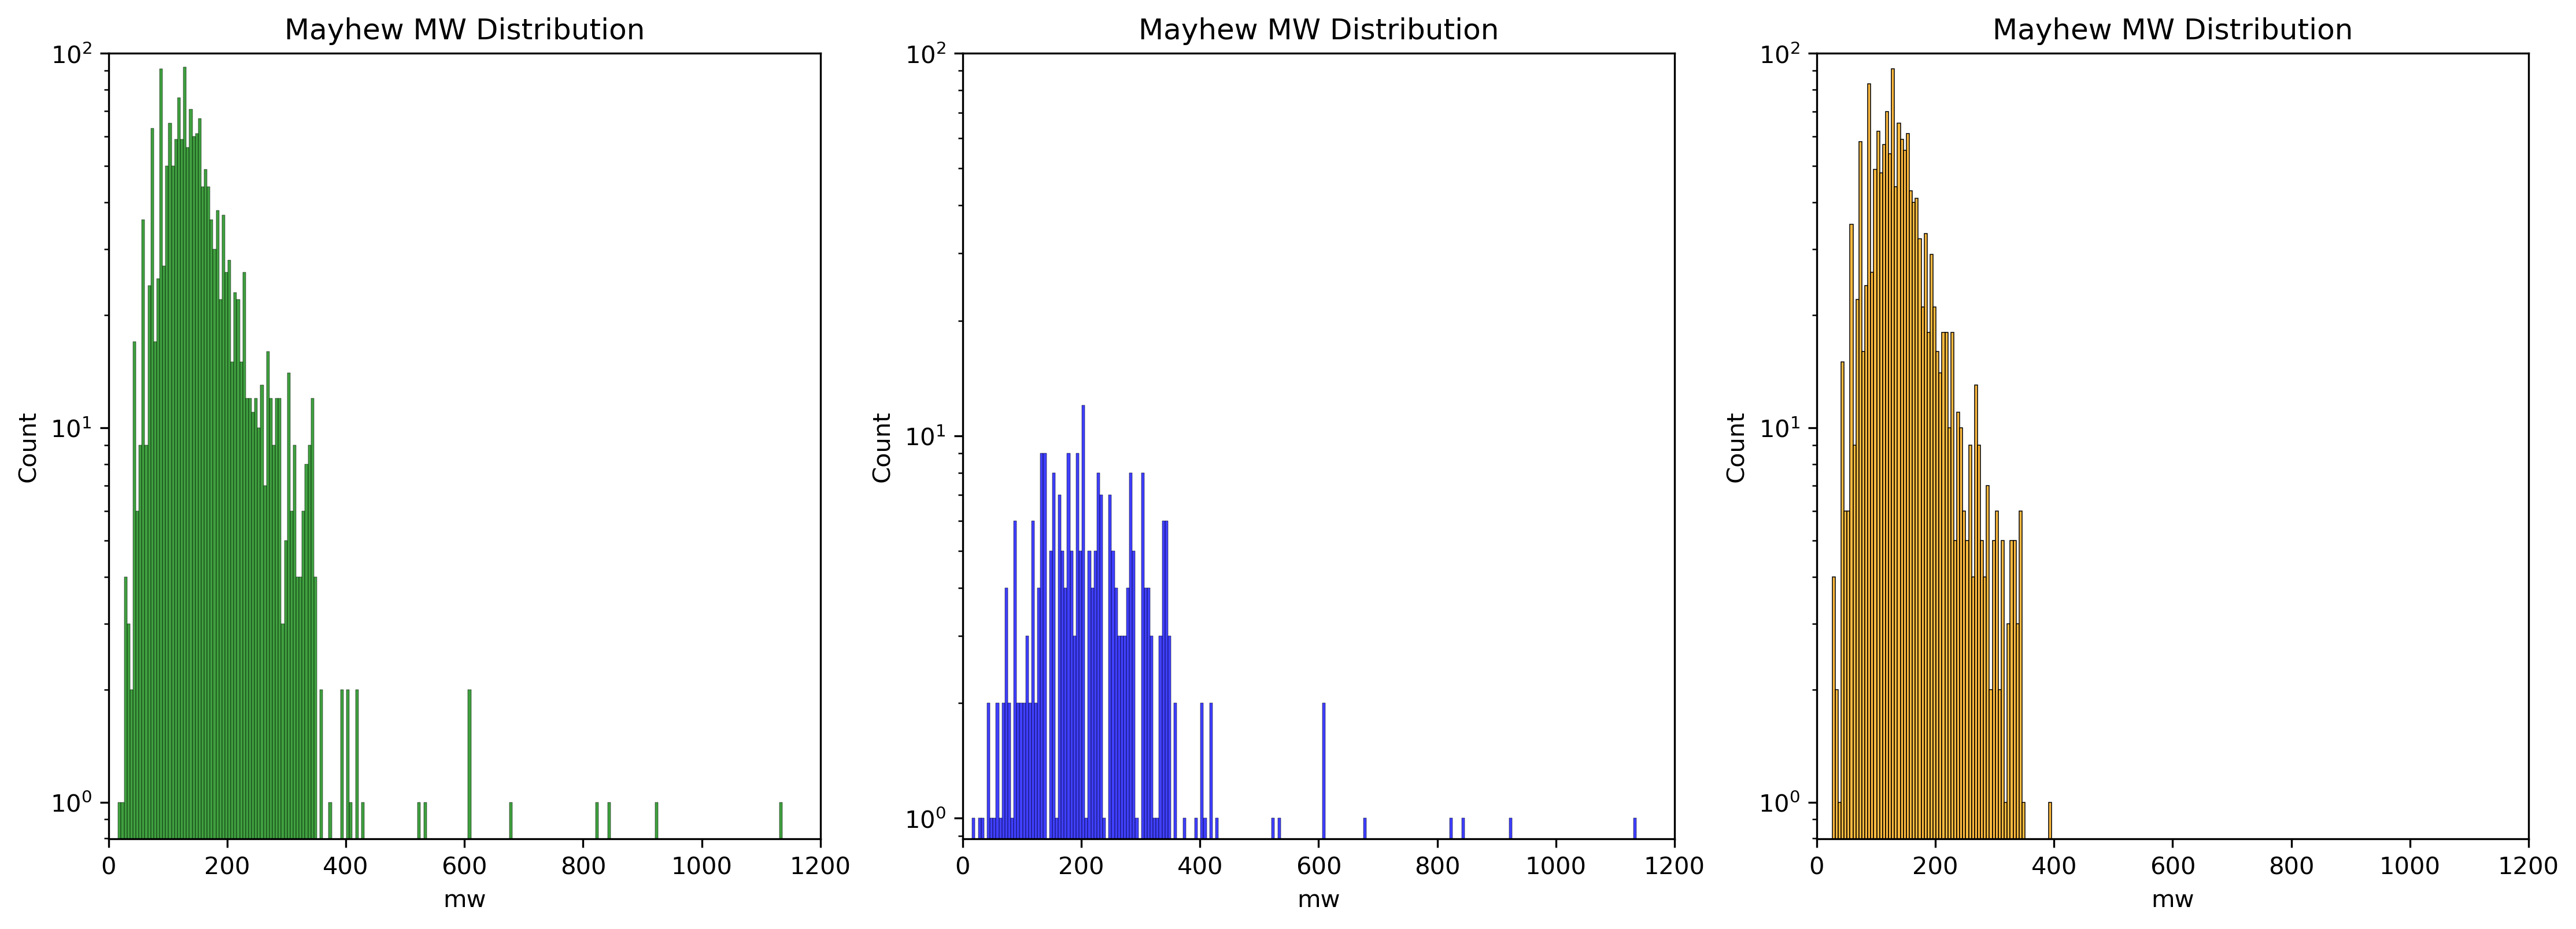

In [38]:
df['mw'] = df.apply(lambda row: ExactMolWt(row['rdkit']), axis=1)

if True:
    fig, ax = plt.subplots(1,3, figsize=(18,6), dpi=300)
    g = sns.histplot(df['mw'], ax=ax[0], binwidth=5, color='green')
    g.set_yscale("log")
    ax[0].set_title("Mayhew MW Distribution")
    ax[0].set_xlim([0,1200])
    ax[0].set_ylim([0,100])

    
    
    g = sns.histplot(df[df['is_odor'] == 0]['mw'], ax=ax[1], binwidth=5, color='b')
    g.set_yscale("log")
    ax[1].set_title("Mayhew MW Distribution")
    ax[1].set_xlim([0,1200])
    ax[1].set_ylim([0, 100])

    g = sns.histplot(df[df['is_odor'] == 1]['mw'], ax=ax[2], binwidth=5, color='orange')
    g.set_yscale("log")
    ax[2].set_title("Mayhew MW Distribution")
    ax[2].set_xlim([0,1200])
    ax[2].set_ylim([0, 100])



else:
    fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
    g = sns.histplot(df['mw'], ax=ax, binwidth=5, color='green')
    ax.set_title("Leffingwell MW Distribution")
    ax.set_xlim([0,450])
    g.set_yscale("log")
    #ax.set_ylim([0, 100])

/home/chertian/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


(19.79856814997601, 3000)

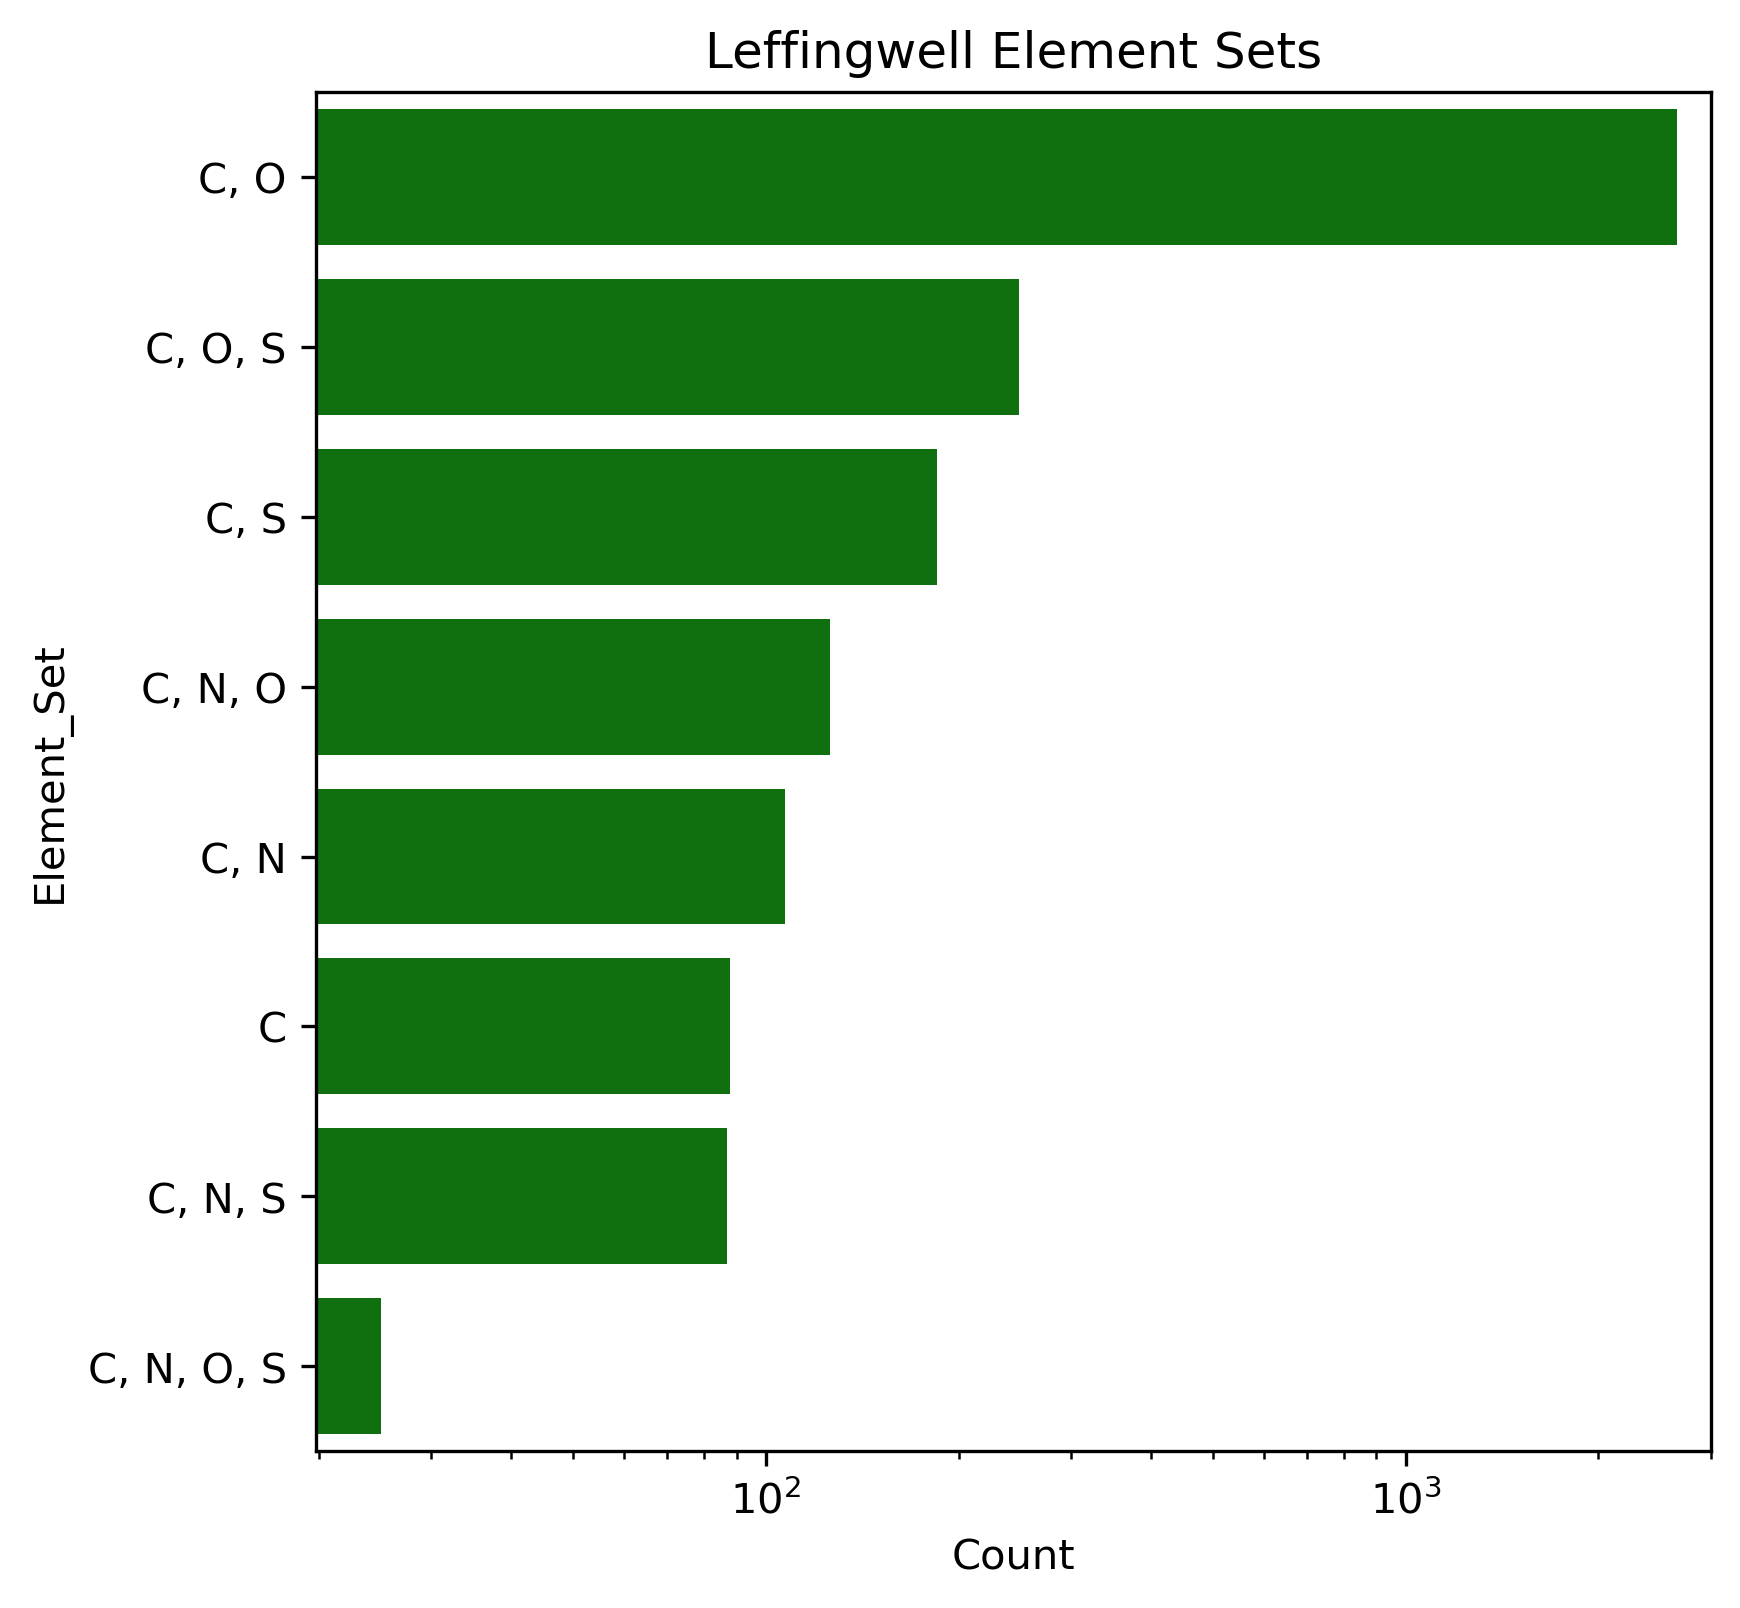

In [10]:
df['Element_Sets'] = df['IsomericSMILES'].apply(get_elements)

# Create a Counter to count the occurrences of each set of elements
element_set_counts = Counter(df['Element_Sets'])

element_set_counts_df = pd.DataFrame(
    list(element_set_counts.items()), 
    columns=['Element_Set', 'Count']
)

# Convert tuple to string for better plotting
element_set_counts_df['Element_Set'] = element_set_counts_df['Element_Set'].apply(lambda x: ', '.join(x))

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
g = sns.barplot(data=element_set_counts_df.sort_values('Count', ascending=False), y='Element_Set', x='Count', color='green', ax=ax, orient="h")

g.set_xscale("log")

ax.set_title("Leffingwell Element Sets")

# Rotate the x-axis labels for better readability
#plt.yticks(rotation=90, ha='center', size=6)
plt.yticks(size=10)

ax.set_xlim([0,3000])


In [11]:
df['chiral'] = df.apply(lambda row: is_chiral(row['rdkit']), axis=1)
df['chiral'].describe()

count      3522
unique        2
top       False
freq       2415
Name: chiral, dtype: object

In [12]:
df['cistrans'] = df.apply(lambda row: check_cis_trans_isomerism(row['rdkit']), axis=1)
df['cistrans'].describe()

count      3522
unique        2
top       False
freq       2951
Name: cistrans, dtype: object

In [ ]:
df['is_odor_bool'] = df.apply(lambda row: bool(row['is_odor']), axis=1)
df['is_odor_bool'].describe()

In [8]:
df.columns[7:-10]

Index(['alcoholic', 'aldehydic', 'alliaceous', 'almond', 'animal', 'anisic',
       'apple', 'apricot', 'aromatic', 'balsamic',
       ...
       'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable', 'violet',
       'warm', 'waxy', 'winey', 'woody'],
      dtype='object', length=113)

In [16]:
type(label_counts)

pandas.core.series.Series

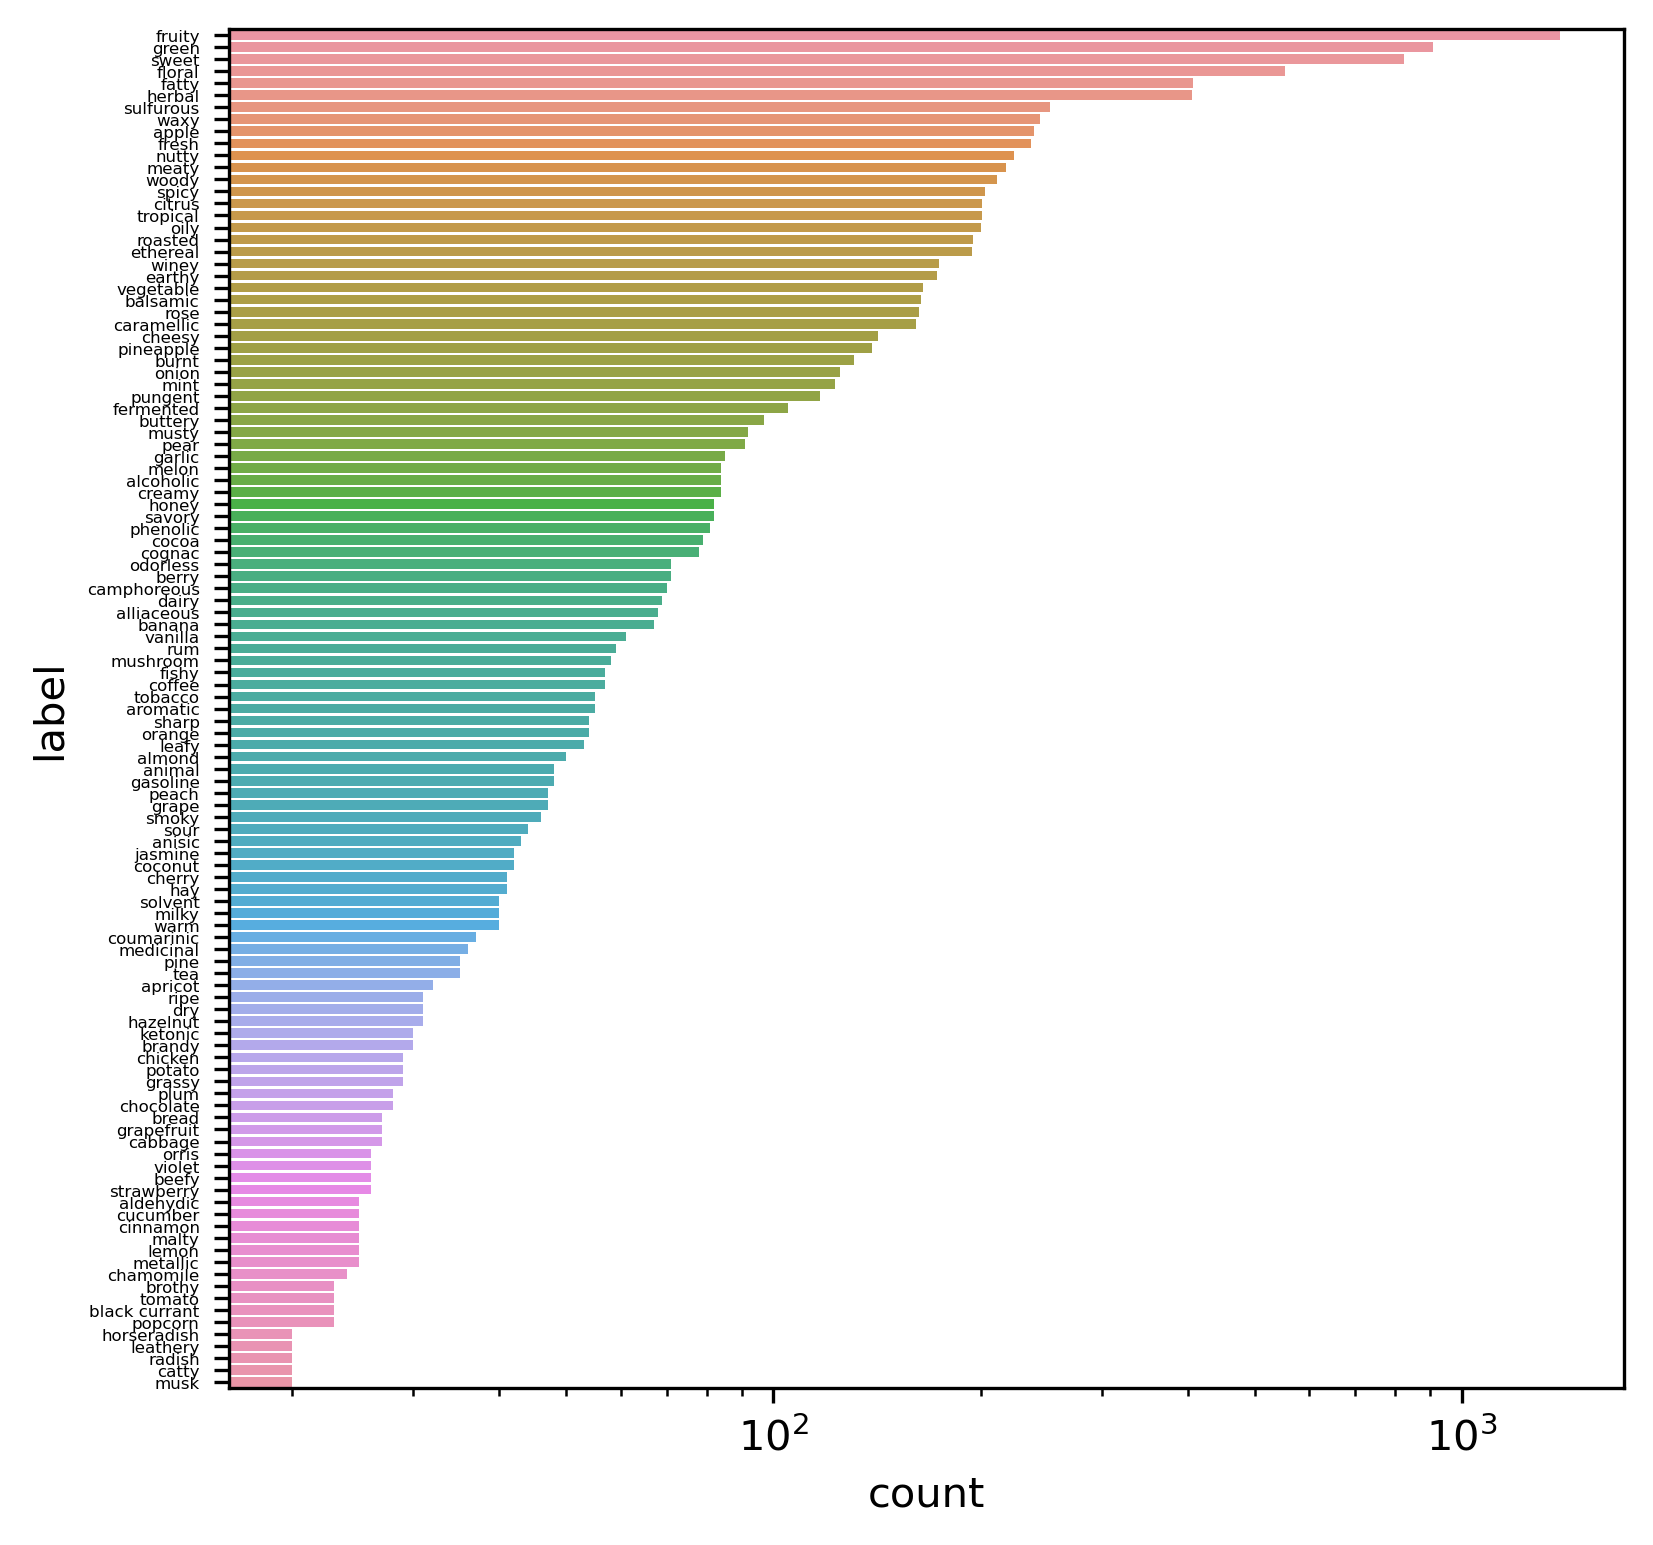

In [24]:
label_counts = df[df.columns[7:-1]].sum()
count_df = label_counts.reset_index()
count_df.columns = ['label', 'count']
count_df.sort_values('count', ascending=False, inplace=True)
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
g = sns.barplot(y='label', x='count', data=count_df, ax=ax, orient='h')
plt.yticks(size=4)
g.set_xscale("log")

In [ ]:
sub_df = df[df.columns[7:-2]]
sub_df['multilabelity'] = sub_df.sum(axis=1)
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
g = sns.histplot(sub_df['multilabelity'], ax=ax, binwidth=1, discrete=True)
ax.set_title("Leffingwell Multilabel")
ax.set_xticks(range(1,10))

In [22]:
data = DataLoader()
data.load_benchmark("mayhew_2022")
data.featurize("rdkit2d_normalized_features")
df = pd.DataFrame(data.features)

Text(0.5, 1.0, 'Mayhew RDKit 2D Normalized (Cosine)')

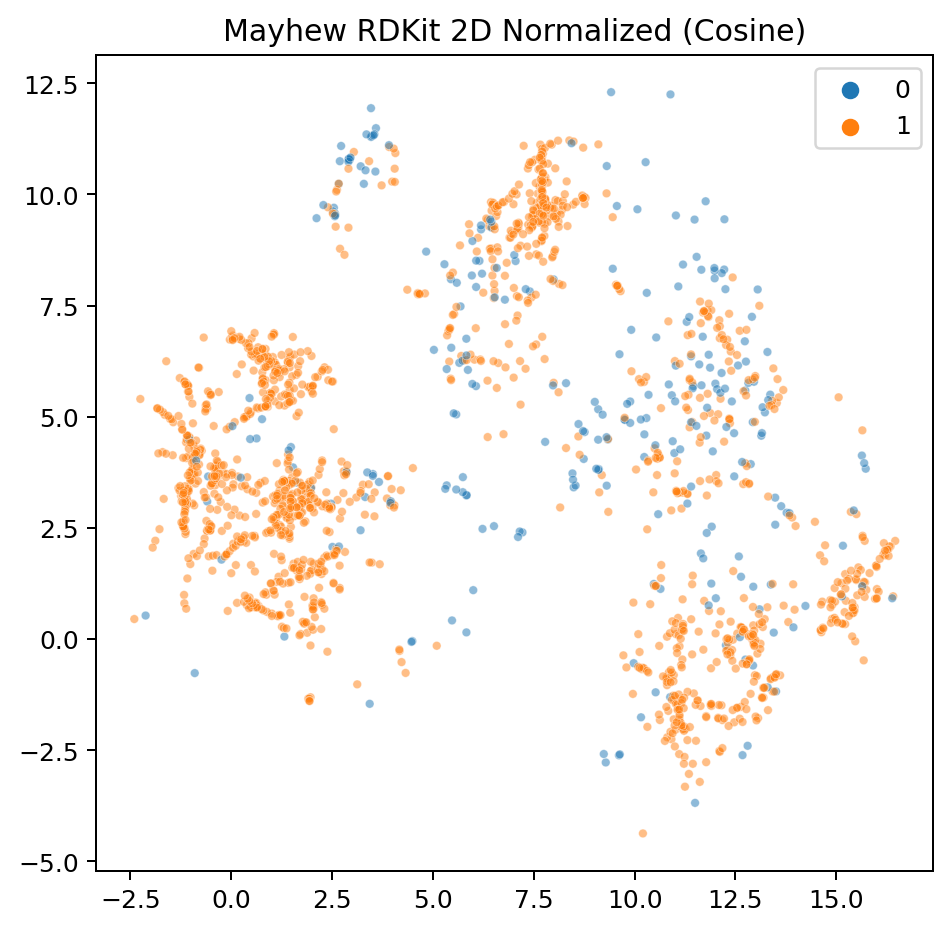

In [23]:
umap_model = umap.UMAP(metric = "cosine",
                       densmap=True,
                       random_state=42,
                       low_memory = False)
X_umap = umap_model.fit_transform(df)
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
g = sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], ax=ax, hue=data.labels.flatten(), s=12, alpha=0.5)
ax.set_title("Mayhew RDKit 2D Normalized (Cosine)")

[0.19768802 0.13716938 0.11910423 0.07913118]


Text(0, 0.5, 'PC1 (13.7%)')

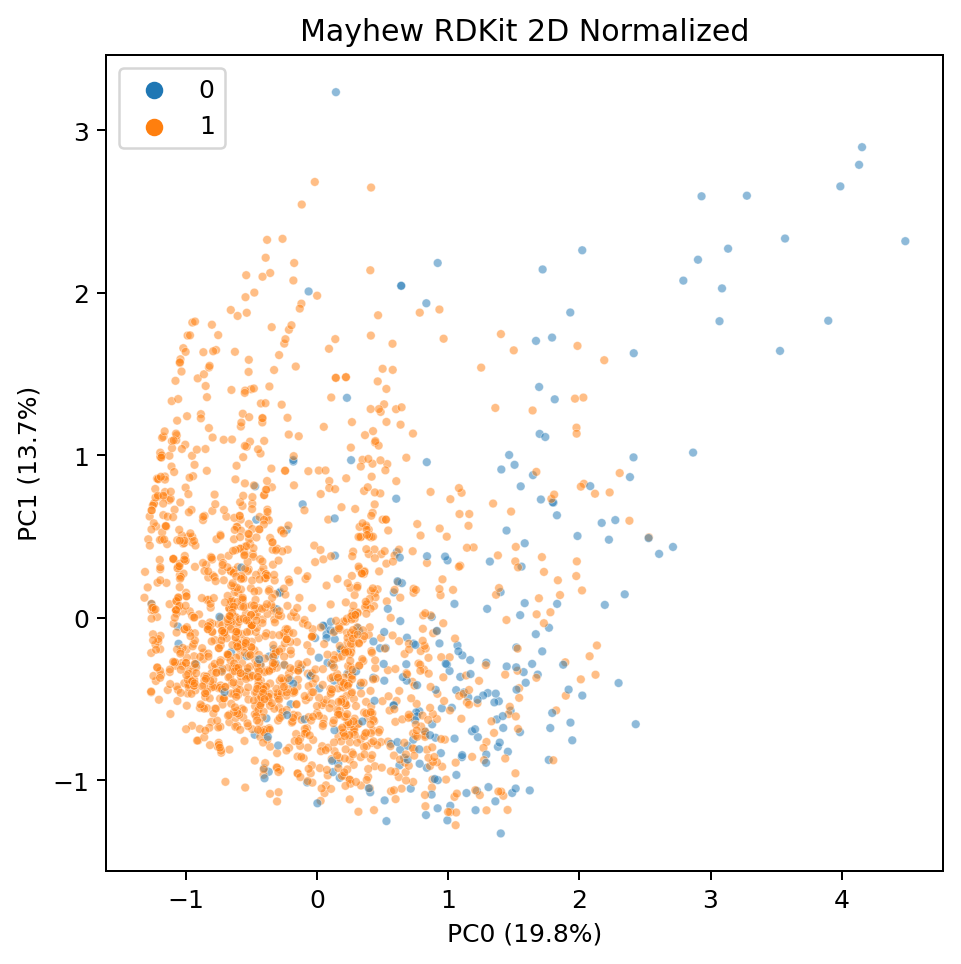

In [24]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(data.features)
print(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
g = sns.scatterplot(x=principalComponents[:, 0], y=principalComponents[:, 1], ax=ax, hue=data.labels.flatten(), s=12, alpha=0.5)
ax.set_title("Mayhew RDKit 2D Normalized")
ax.set_xlabel(f"PC0 ({pca.explained_variance_ratio_[0]*100:.01f}%)")
ax.set_ylabel(f"PC1 ({pca.explained_variance_ratio_[1]*100:.01f}%)")

Text(0.5, 1.0, 'Mayhew RDKit 2D Normalized PC Cumulative')

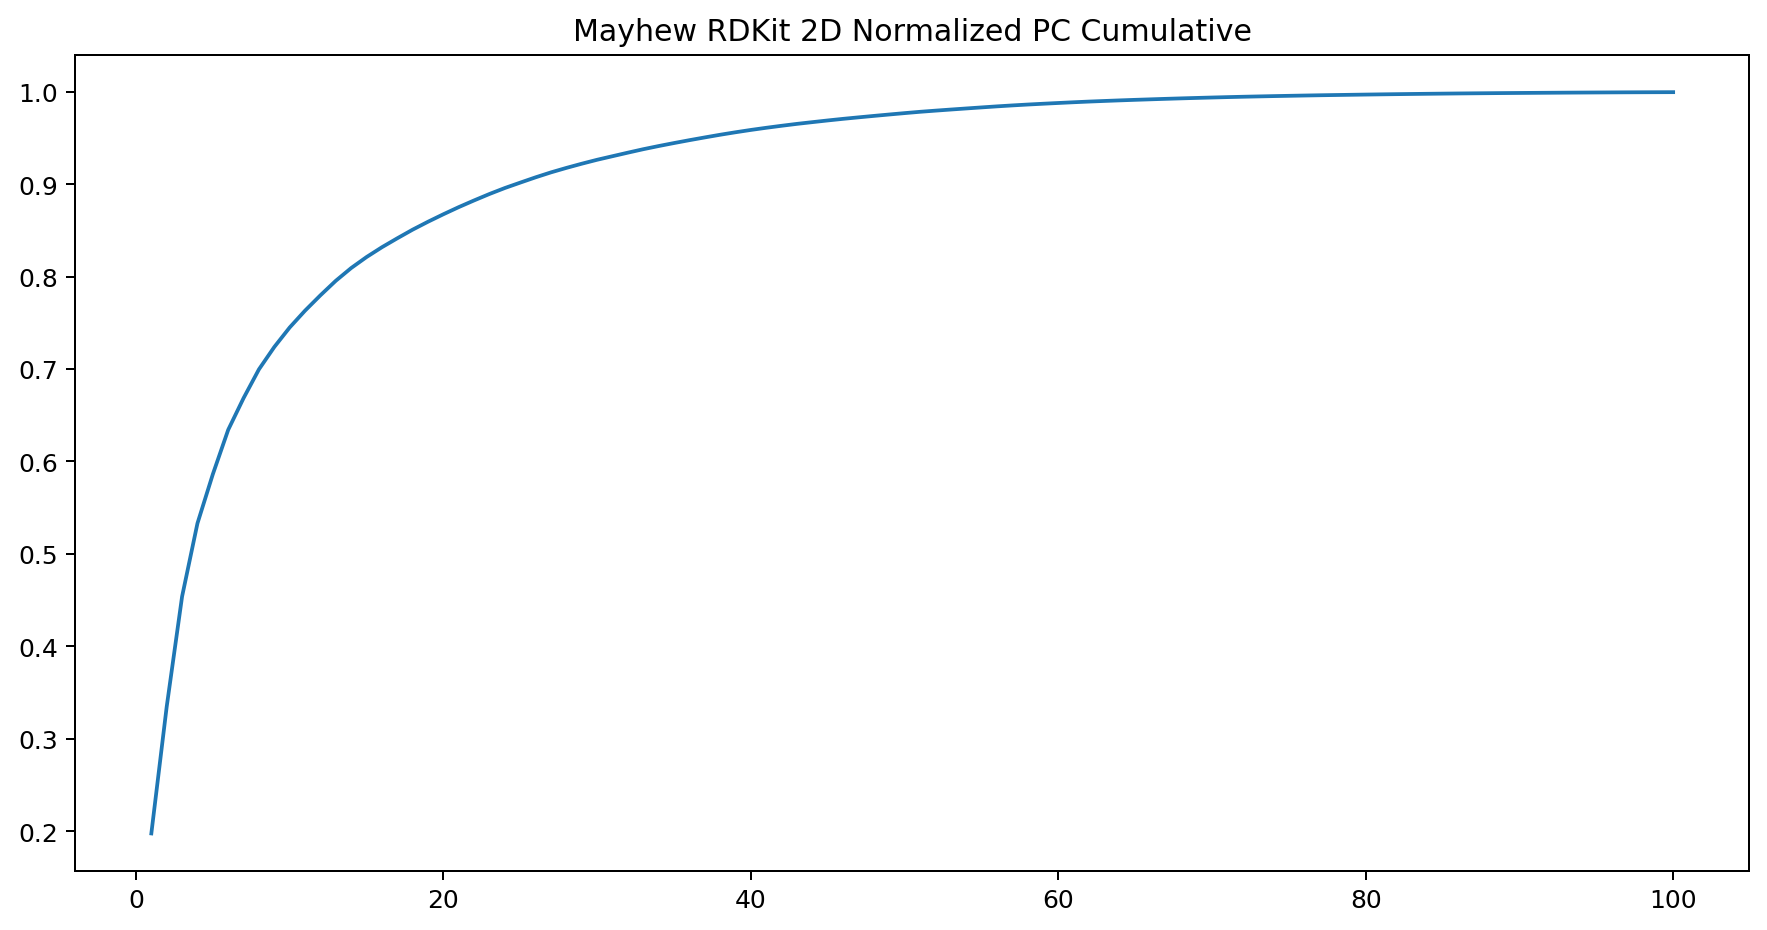

In [25]:
pca = PCA(n_components=100)
principalComponents = pca.fit_transform(data.features)
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=180)
g = sns.lineplot(x=range(1,len(cumulative_variance_explained)+1), y=cumulative_variance_explained)
ax.set_title("Mayhew RDKit 2D Normalized PC Cumulative")